# Выбор архитектуры модели для сегментации типов ландшафта по данным аэрофотосъемки

## Содержание

* [Задача](#Задача)
* [Исследуемые параметры](#Исследуемые-параметры)
* [Измеряемые характеристики](#Измеряемые-характеристики)
* [Описание исследования](#Описание-исследования)
* [Результат исследования](#Результат-исследования)
* [Вывод](#Вывод)

## Задача

Изучить влияние архитектуры сети и её параметров на качество модели и выбрать оптимальные значения.

## Исследуемые параметры

* Архитектура сети.
* Количество блоков.
* Количество фильров в блоках.
* Наличие dropblock слоя в блоках.

## Измеряемые характеристики

Метрика IoU на тестовой части датасета.

## Описание исследования

Импорты библиотек и вспомогательных скриптов

In [1]:
import sys
sys.path.append('../')

from datetime import datetime

import numpy as np
from matplotlib import pyplot as plt
import tensorflow as tf

from srr.batchflow import FilesIndex, Dataset, Pipeline, F, V, B, C, R, P
from srr.batchflow.models.tf import UNet
from srr.batchflow.research import Research, Results, Option, Grid

from srr import AerialBatch
from srr.core.utils import get_origs, ce_dice_loss, make_mask

Классы из маски, которые будут использованы при обучении:

In [2]:
classes = (1,)

Задание датасета

In [3]:
ind = FilesIndex(path='../ignore/GPN_AERO_FOREST/*.tif')
ads = Dataset(ind, AerialBatch)
ads.split(0.8, shuffle=False)

Задание модели

In [4]:
model_config = {
    'initial_block/inputs': 'images',
    'inputs': dict(images={'shape': B('image_shape')}, 
                   masks={'name':'targets',
                          'shape': (256, 256, len(classes)+1)}),
    'filters': C('filters'),
    'layout': C('layout'),
    'head/num_classes': len(classes)+1,
    'loss': (ce_dice_loss, {'alpha': 0.85}),
    'optimizer': 'Adam',
    'output': ['proba'],
}

Описание пайплайнов для обучения и оценки моделей

In [5]:
n_reps = 4
batch_size = 8
n_epochs = 300
n_iters = int(n_epochs * (len(ads.train) / batch_size))
iters_to_test = 300
itt = "%{}".format(iters_to_test)

print("Total number of iterations: {}.\nTest after each {} iterations.".format(n_iters, iters_to_test))

folder = '../ignore/research/orto_forestation_' + datetime.now().strftime(format='%Y%m%d%H%M')

Total number of iterations: 2437.
Test after each 300 iterations.


In [6]:
crop_shape = (256, 256)

train_template = (
      Pipeline()
      .load(ind, fmt='image', dst='images')
      .load(ind, fmt='mask', dst='masks')
      .scale(factor=P(R('uniform', 0.16, 0.24)), src=['images', 'masks'], dst=['images', 'masks'])
      .apply_transform(get_origs, classes=classes, crop_shape=crop_shape, proba=0., src='masks', dst='origs')
      .crop(shape=crop_shape, src=[('images', 'origs'), ('masks', 'origs')], dst=['images', 'masks'])
      .rotate(P(R('randint', 0, 180)), src=['images', 'masks'], dst=['images', 'masks'], p=.9)
      .flip('lr', src=['images', 'masks'], dst=['images', 'masks'], p=0.9)
      .enhance(factor=P(R('uniform', 0.8, 1.2)))
      .to_array(src=['images', 'masks'], dst=['images', 'masks'])
      .apply_transform(make_mask, classes=classes, src='masks', dst='masks')
      .init_variable('loss', init_on_each_run=list)
      .init_model('dynamic', C('model'), 'unet', model_config)
      .train_model('unet', images=B('images'), targets=B('masks'),
                      fetches='loss', save_to=V('loss', mode='w'))
).run(batch_size, n_epochs=n_epochs, shuffle=True, lazy=True, drop_last=True)

test_template = (
      Pipeline()    
      .load(ind, fmt='image', dst='images')
      .load(ind, fmt='mask', dst='masks')
      .scale(factor=P(R('uniform', 0.16, 0.24)), src=['images', 'masks'], dst=['images', 'masks'])
      .apply_transform(get_origs, classes=classes, crop_shape=crop_shape, proba=0., src='masks', dst='origs')
      .crop(shape=crop_shape, src=[('images', 'origs'), ('masks', 'origs')], dst=['images', 'masks'])
      .to_array(src=['images', 'masks'], dst=['images', 'masks'])
      .apply_transform(make_mask, classes=classes, src='masks', dst='masks')
      .init_variable('predictions', init_on_each_run=list)
      .init_variable('metrics', init_on_each_run=None)
      .import_model('unet', C('import_from'))
      .predict_model('unet', images=B('images'), targets=B('masks'),
                   fetches=['proba'], save_to=[V('predictions', mode='w')])
      .gather_metrics('segmentation', axis=-1, targets=B('masks'), predictions=V('predictions'),
                      fmt='proba', save_to=V('metrics', mode='u'))
).run(batch_size, n_epochs=1, lazy=True, drop_last=True)

Описание варьируемых параметров

In [7]:
model_opts = Option('model', [UNet])

filter_opts = Option('filters', [[32, 64, 128],
                                 [16, 32, 64, 128, 256],
                                 [32, 64, 128, 256]
                                ])
layout_opts = Option('layout', ['cnacna',
                                'cnaDcnaD',
                                'cna'])

opts = filter_opts * layout_opts * model_opts

Вспомогательная функция для расчёта метрик на лету:

In [8]:
def get_metric(iteration, experiment, pipeline, metric='iou'):
    pipeline = experiment[pipeline].pipeline
    metrics = pipeline.get_variable('metrics')
    return metrics.evaluate(metric)

Описание эксперимента

In [9]:
train_ppl = (train_template << ads.train)
test_ppl = (test_template << ads.test)

research = (Research()
            .add_pipeline(train_ppl, name='train', variables='loss')
            .add_pipeline(test_ppl, execute=itt, name='test', run=True, import_from='train')
            .add_grid(opts)
            .add_function(get_metric, returns='metric', name='test_metric', execute=itt, dump=itt, pipeline='test')
           )

In [ ]:
research.run(n_reps=n_reps, n_iters=n_iters, workers=6, name=folder, bar=True, gpu=[0,1,2,3,4,5])

Research ../ignore/research/orto_forestation_201907112035 is starting...


  0%|          | 0/87732 [00:00<?, ?it/s]

Distributor has 36 jobs with 2437 iterations. Totally: 87732


 10%|█         | 9019/87732 [1:09:18<10:04:51,  2.17it/s]

## Результат исследования

In [11]:
df = Results(path=folder).load(use_alias=True)

### Графики целевой метрики IoU

Model configuration: 
filters_[32, 64, 128]-layout_cnacna-model_UNet


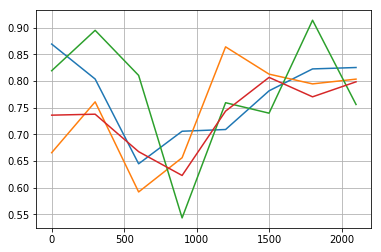

Model configuration: 
filters_[32, 64, 128]-layout_cnaDcnaD-model_UNet


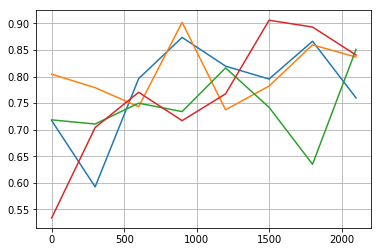

Model configuration: 
filters_[32, 64, 128]-layout_cna-model_UNet


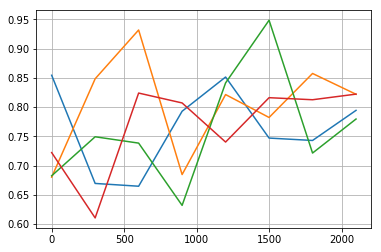

Model configuration: 
filters_[16, 32, 64, 128, 256]-layout_cnacna-model_UNet


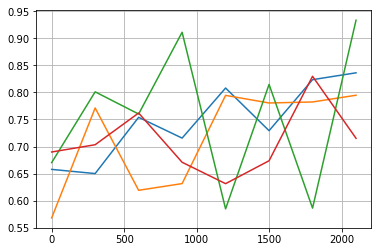

Model configuration: 
filters_[16, 32, 64, 128, 256]-layout_cnaDcnaD-model_UNet


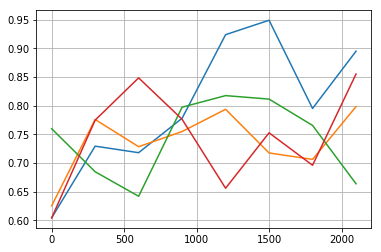

Model configuration: 
filters_[16, 32, 64, 128, 256]-layout_cna-model_UNet


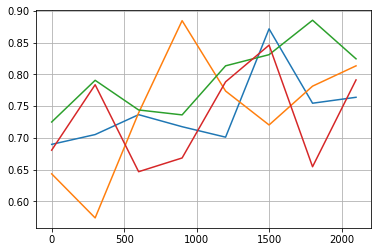

Model configuration: 
filters_[32, 64, 128, 256]-layout_cnacna-model_UNet


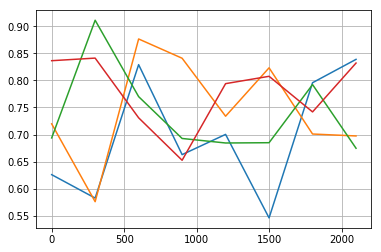

Model configuration: 
filters_[32, 64, 128, 256]-layout_cnaDcnaD-model_UNet


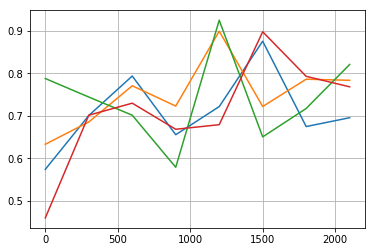

Model configuration: 
filters_[32, 64, 128, 256]-layout_cna-model_UNet


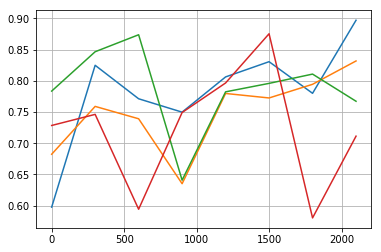

In [13]:
for conf in df.config.unique():
    print("Model configuration: \n{}".format(conf))
    for rep in df.repetition.unique():
        condition = (df.name=='test_metric')&(df.config==conf)&(df.repetition==rep)
        values = df[condition]['metric']
        iters = np.arange(len(values)) * iters_to_test
        plt.plot(iters, values)
        plt.grid(True)
    plt.show()

### Графики функции потерь

Model configuration: 
filters_[32, 64, 128]-layout_cnacna-model_UNet


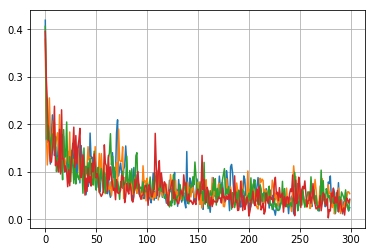

Model configuration: 
filters_[32, 64, 128]-layout_cnaDcnaD-model_UNet


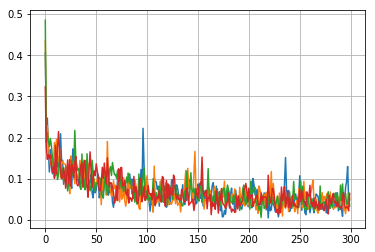

Model configuration: 
filters_[32, 64, 128]-layout_cna-model_UNet


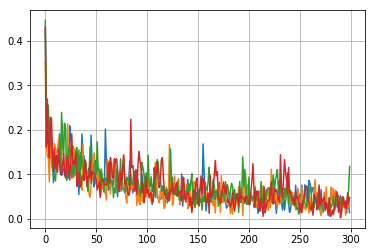

Model configuration: 
filters_[16, 32, 64, 128, 256]-layout_cnacna-model_UNet


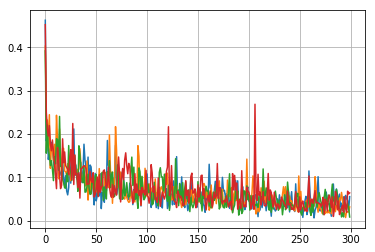

Model configuration: 
filters_[16, 32, 64, 128, 256]-layout_cnaDcnaD-model_UNet


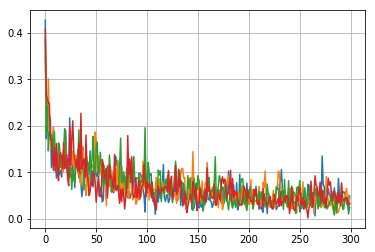

Model configuration: 
filters_[16, 32, 64, 128, 256]-layout_cna-model_UNet


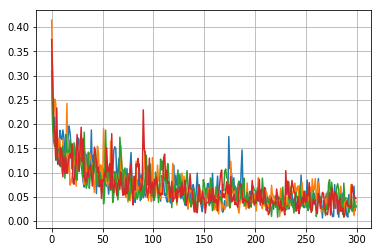

Model configuration: 
filters_[32, 64, 128, 256]-layout_cnacna-model_UNet


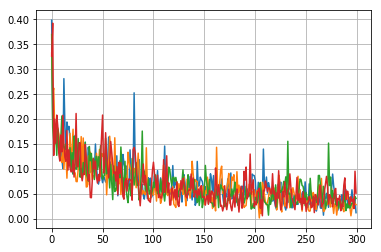

Model configuration: 
filters_[32, 64, 128, 256]-layout_cnaDcnaD-model_UNet


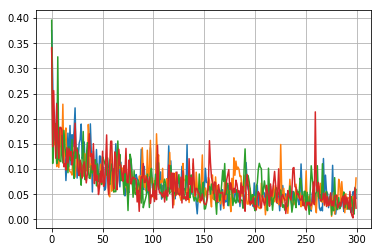

Model configuration: 
filters_[32, 64, 128, 256]-layout_cna-model_UNet


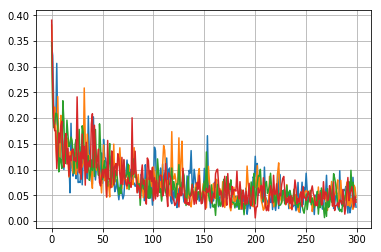

In [14]:
for conf in df.config.unique():
    print("Model configuration: \n{}".format(conf))
    for rep in df.repetition.unique():
        condition = (df.name=='train')&(df.config==conf)&(df.repetition==rep)
        loss_ep = np.array(np.split(df[condition]['loss'], n_epochs))
        loss_mean = np.mean(loss_ep, axis=-1)
        plt.plot(loss_mean)
        plt.grid(True)
    plt.show()

### Усреднённые графики целевой метрики с 95% доверительным интервалом

Model configuration: 
filters_[32, 64, 128]-layout_cnacna-model_UNet


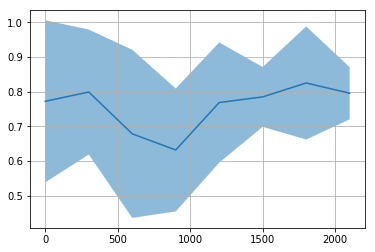

Model configuration: 
filters_[32, 64, 128]-layout_cnaDcnaD-model_UNet


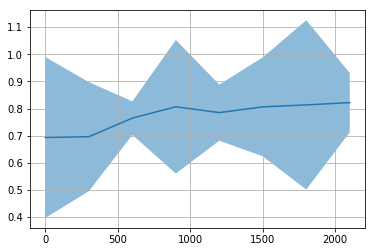

Model configuration: 
filters_[32, 64, 128]-layout_cna-model_UNet


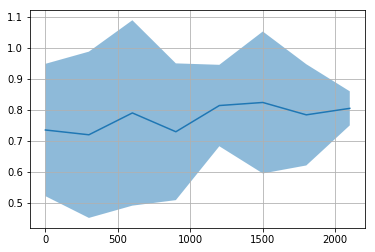

Model configuration: 
filters_[16, 32, 64, 128, 256]-layout_cnacna-model_UNet


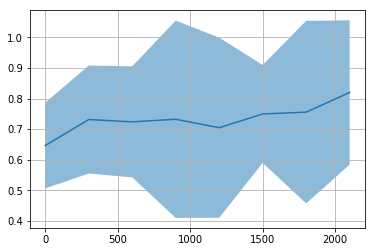

Model configuration: 
filters_[16, 32, 64, 128, 256]-layout_cnaDcnaD-model_UNet


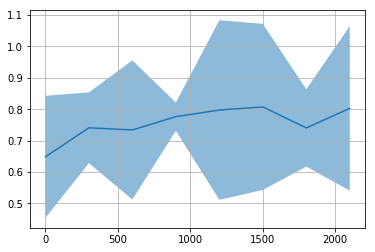

Model configuration: 
filters_[16, 32, 64, 128, 256]-layout_cna-model_UNet


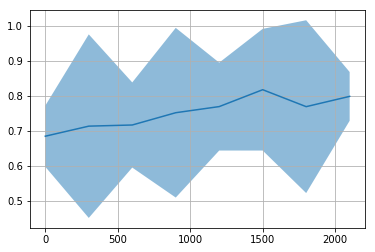

Model configuration: 
filters_[32, 64, 128, 256]-layout_cnacna-model_UNet


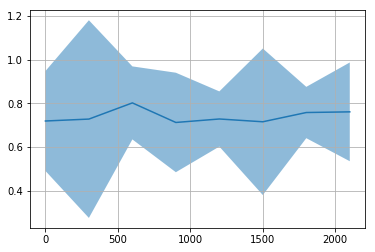

Model configuration: 
filters_[32, 64, 128, 256]-layout_cnaDcnaD-model_UNet


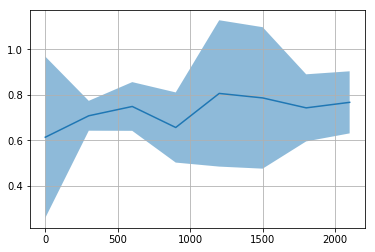

Model configuration: 
filters_[32, 64, 128, 256]-layout_cna-model_UNet


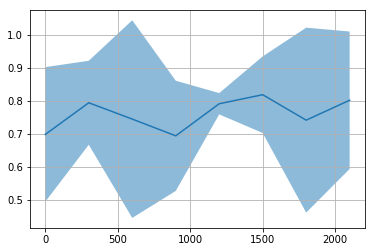

In [17]:
for conf in df.config.unique():
    print("Model configuration: \n{}".format(conf))
    values = []
    for rep in df.repetition.unique():
        condition = (df.name=='test_metric')&(df.config==conf)&(df.repetition==rep)
        values.append(df[condition]['metric'])
        iters = np.arange(len(values[0])) * iters_to_test
    values = np.array(values)
    mean = np.mean(values, axis=0)
    std = np.std(values, axis=0)
    plt.plot(iters, mean)
    plt.fill_between(iters, mean-2*std, mean+2*std, alpha=.5)
    plt.grid(True)
    plt.show()

### Усреднённые графики функции потерь с 95% доверительным интервалом

Model configuration: 
filters_[32, 64, 128]-layout_cnacna-model_UNet


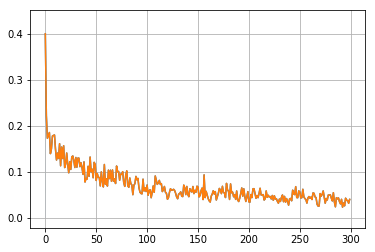

Model configuration: 
filters_[32, 64, 128]-layout_cnaDcnaD-model_UNet


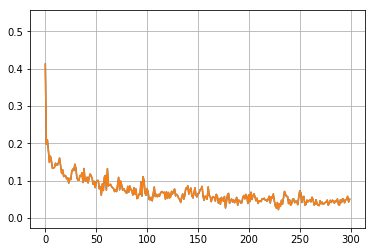

Model configuration: 
filters_[32, 64, 128]-layout_cna-model_UNet


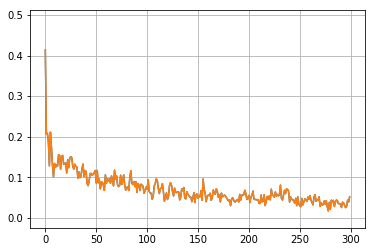

Model configuration: 
filters_[16, 32, 64, 128, 256]-layout_cnacna-model_UNet


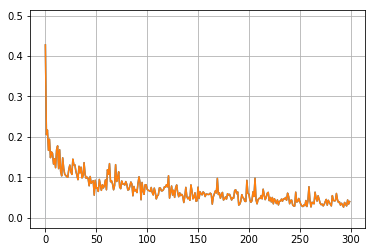

Model configuration: 
filters_[16, 32, 64, 128, 256]-layout_cnaDcnaD-model_UNet


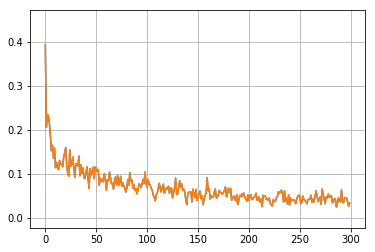

Model configuration: 
filters_[16, 32, 64, 128, 256]-layout_cna-model_UNet


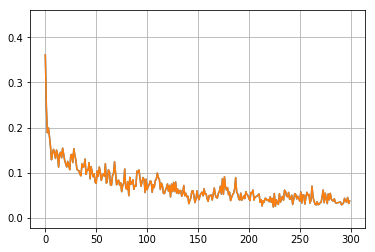

Model configuration: 
filters_[32, 64, 128, 256]-layout_cnacna-model_UNet


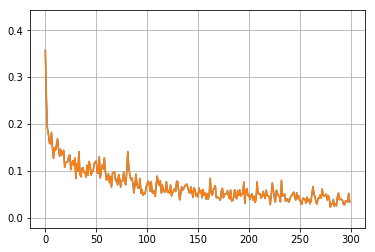

Model configuration: 
filters_[32, 64, 128, 256]-layout_cnaDcnaD-model_UNet


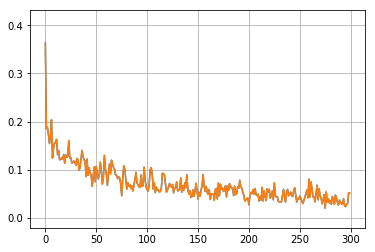

Model configuration: 
filters_[32, 64, 128, 256]-layout_cna-model_UNet


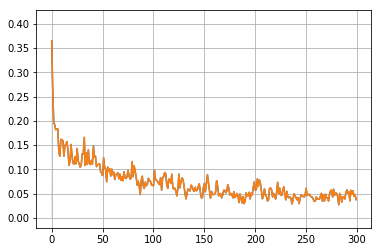

In [25]:
for conf in df.config.unique():
    print("Model configuration: \n{}".format(conf))
    loss = []
    for rep in df.repetition.unique():
        condition = (df.name=='train')&(df.config==conf)&(df.repetition==rep)
        loss_ep = np.array(np.split(df[condition]['loss'], n_epochs))
        loss.append(np.mean(loss_ep, axis=-1))
    loss_mean = np.mean(loss, 0)
    std = np.std(loss, axis=0)
    plt.plot(loss_mean)
    plt.fill_between(loss_mean-2*std, loss_mean+2*std, alpha=.5)

    plt.plot(loss_mean)
    plt.grid(True)
    plt.show()

## Вывод

Исследование показало, что качество модели слабо зависит от количества фильтров и числа блоков. При этом конфигурация блока с одной конволюцией `cna` в среднем показывает больший разброс метрики и менее хороший результат. Влияние `Dropblock` не однозначно, но имеет тенденцию к уменьшению разброса метрики. 

По этом результатам рекоменуется использовать конфигурацию блока `cnaDcnaD`, и количество блоков / фильтров `[32, 64, 128]`. Также перспективным может быть конфигурация `[16, 32, 64, 128, 256]`. 